In [1]:
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
import pandas as pd
from ast import literal_eval
import numpy as np
from pickle import load
import matplotlib.pyplot as plt

In [3]:
from matplotlib import rc
rc('text', usetex=False)
rc('font', **{'family': 'serif', 'size' : 12})
rc('figure', **{'figsize' : (5, 3)})

In [5]:
loss_dict = load(
        open("models/article_ressources/loss_dict_2500_PS.pkl", "rb")
    )
loss_dict.keys()

dict_keys(['train_loss', 'val_loss'])

In [6]:
print(loss_dict['val_loss'][np.argmin(loss_dict['val_loss'])], np.argmin(loss_dict['val_loss']), loss_dict['train_loss'][np.argmin(loss_dict['val_loss'])])

0.0012984737902879714 2427 0.002217081069946289


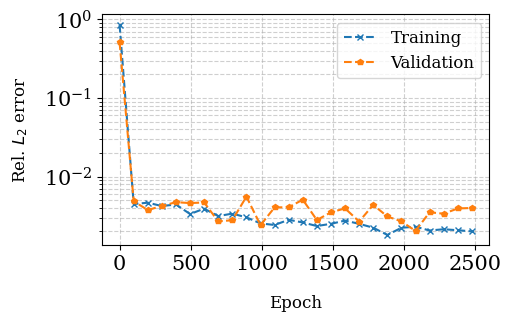

In [7]:
fig, ax = plt.subplots(1, 1)

l2_err_train = loss_dict['train_loss']
l2_err_val = loss_dict['val_loss']

ax.plot(range(0, 2500, 99), l2_err_train[::99], '--x', markersize=4, label='Training')
ax.plot(range(0, 2500, 99), l2_err_val[::99], '--p', markersize=4, label='Validation')

ax.set_ylabel('Rel. $L_2$ error', size=12, labelpad = 10)

ax.grid(True, which='both', alpha = .6, ls='dashed')
ax.set_yscale('log')
ax.set_xlabel('Epoch', fontsize = 12, labelpad=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.ticklabel_format(style='sci', axis='x')
ax.legend()
# plt.savefig('l2_loss_darcy.pdf', bbox_inches = 'tight')
plt.show()

In [8]:
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

In [9]:
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = (
            modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        )

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(
            self.scale
            * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat)
        )

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(
            batchsize,
            self.out_channels,
            x.size(-1) // 2 + 1,
            device=x.device,
            dtype=torch.cfloat,
        )
        out_ft[:, :, : self.modes1] = self.compl_mul1d(
            x_ft[:, :, : self.modes1], self.weights1
        )

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv1d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv1d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x


class FNO1d(nn.Module):
    def __init__(self, modes, width, n_in_features, n_out_features):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 6  # pad the domain if input is non-periodic
        self.n_features = n_in_features

        self.p = nn.Linear(n_in_features, self.width)
        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.q = MLP(self.width, n_out_features, self.width * 2)

    def forward(self, x):
        x = self.p(x)
        x = x.permute(0, 2, 1)

        x = F.pad(x, [0, self.padding])  # pad the domain if input is non-periodic
        x1 = self.conv0(x)
        x1 = self.mlp0(x1)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., : -self.padding]  # pad the domain if input is non-periodic
        x = self.q(x)
        x = x.permute(0, 2, 1)
        return x

# PS model

In [10]:
SP_model = FNO1d(modes = 12, width = 128, n_in_features=3, n_out_features=2)
SP_model.load_state_dict(
        torch.load(
            "models/article_ressources/checkpoint_best_model_CEMRACS_Manuscrit_2500_PS.pt",
            map_location=torch.device("cpu"),
        )
    )

<All keys matched successfully>

In [13]:
train_df = pd.read_csv("data/train.csv", sep="\t", converters={"S": literal_eval, "S0": literal_eval, 'P': literal_eval, 'P_init': literal_eval, 'Pb': literal_eval})

In [11]:
P_normalizer = load(
        open("models/article_ressources/P_normalizer_PS.pkl", "rb")
    )

In [14]:
sample = train_df.loc[0]

In [15]:
P0 = torch.from_numpy(np.array(sample['P_init'])).reshape(1, -1, 1)
S0 = torch.from_numpy(np.array(sample['S0'])).reshape(1, -1, 1)
Pb = torch.from_numpy(np.full(shape=(1, 100, 1), fill_value= sample['Pb']['left']))
P0_norm = P_normalizer.encode(P0)
Pb_norm = P_normalizer.encode(Pb)
input = torch.cat([S0, P0_norm, Pb_norm], 2).float()
SP_pred = SP_model(input).detach()
S_pred = SP_pred[:, :, 0].numpy()
P_pred = P_normalizer.decode(SP_pred[:, :, 1].unsqueeze(-1)).numpy()

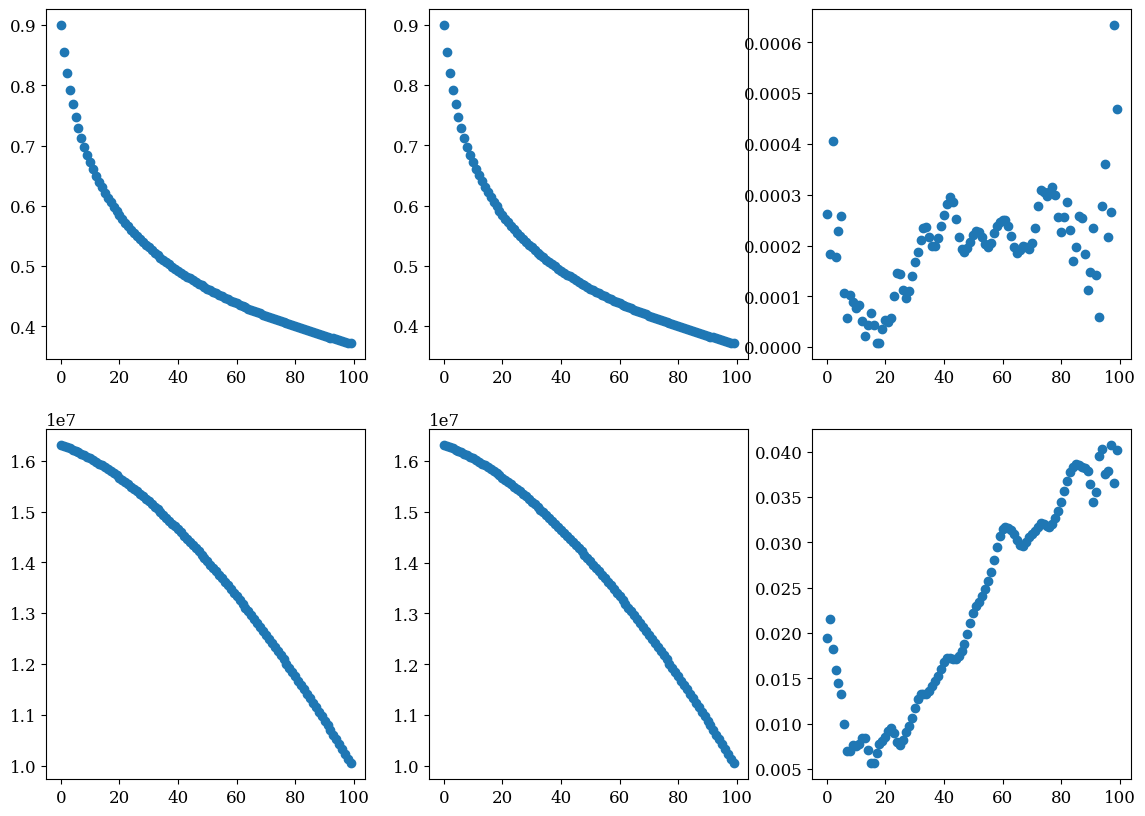

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(14, 10))
x = range(len(sample['S0']))
axs[0][0].scatter(x, sample['S'])
axs[0][1].scatter(x, S_pred.flatten())

axs[1][0].scatter(x, sample['P'])
axs[1][1].scatter(x, P_pred.flatten())

axs[0][2].scatter(x, np.abs(S_pred.flatten() - sample['S']))
axs[1][2].scatter(x, (np.abs(P_pred.flatten() - sample['P']))/np.abs(sample['P']) * 100)

plt.show()

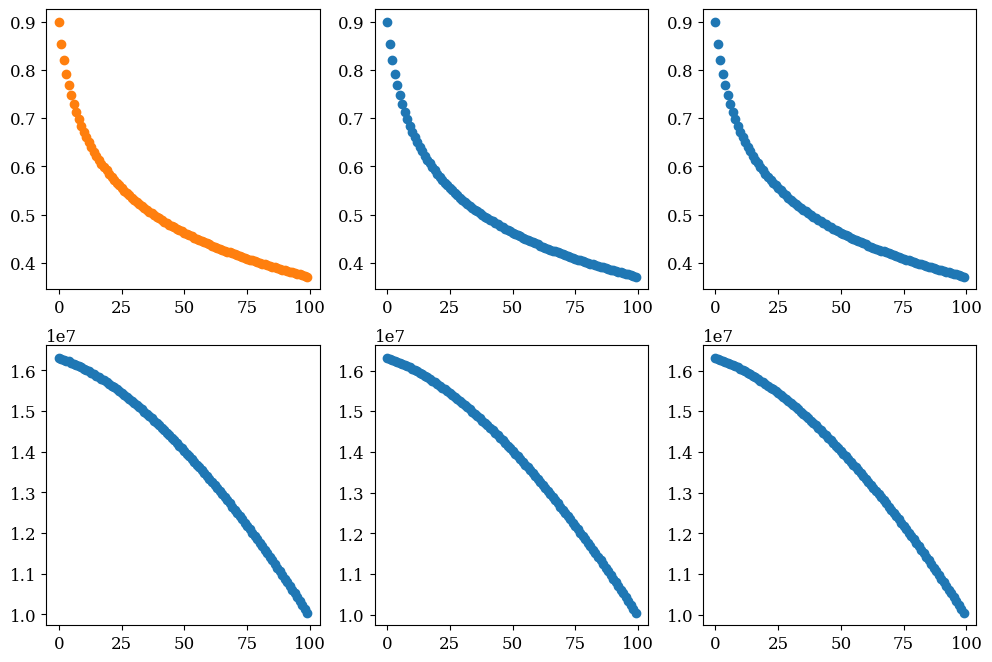

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
x = range(len(sample['S0']))

axs[0][0].scatter(x, sample['S'], s=5)
axs[0][0].scatter(x, S_pred.flatten())

axs[0][1].scatter(x, S_pred.flatten())
axs[0][2].scatter(x, S_pred.flatten())

axs[1][0].scatter(x, sample['P'])
axs[1][1].scatter(x, P_pred.flatten())
axs[1][2].scatter(x, P_pred.flatten())


plt.show()

In [18]:
train_df = pd.read_csv("data/train.csv", sep="\t", converters={"S": literal_eval, "S0": literal_eval, 'P': literal_eval, 'P_init': literal_eval, 'Pb': literal_eval})
test_df = pd.read_csv("data/test.csv", sep="\t", converters={"S": literal_eval, "S0": literal_eval, 'P': literal_eval, 'P_init': literal_eval, 'Pb': literal_eval})
val_df = pd.read_csv("data/validation.csv", sep="\t", converters={"S": literal_eval, "S0": literal_eval, 'P': literal_eval, 'P_init': literal_eval, 'Pb': literal_eval})

In [19]:
# Parity plot
# Train
S0 = torch.from_numpy(np.array([np.array(v).reshape(100, 1) for v in train_df['S0'].values]))
P0 = torch.from_numpy(np.array([np.array(v).reshape(100, 1) for v in train_df['P_init'].values]))

P_train = torch.from_numpy(np.array([np.array(v).reshape(100, 1) for v in train_df['P'].values]))
S_train = torch.from_numpy(np.array([np.array(v).reshape(100, 1) for v in train_df['S'].values]))
Pb = torch.from_numpy(np.array([np.full((100,1), v['left']) for v in train_df['Pb'].values]))
P = P_normalizer.encode(P_train)
P0 = P_normalizer.encode(P0)
Pb = P_normalizer.encode(Pb)
input = torch.cat([S0, P0, Pb], 2).float()
SP_pred_train = SP_model(input).detach()

# Test
S0 = torch.from_numpy(np.array([np.array(v).reshape(100, 1) for v in test_df['S0'].values]))
P0 = torch.from_numpy(np.array([np.array(v).reshape(100, 1) for v in test_df['P_init'].values]))

P_test = torch.from_numpy(np.array([np.array(v).reshape(100, 1) for v in test_df['P'].values]))
S_test = torch.from_numpy(np.array([np.array(v).reshape(100, 1) for v in test_df['S'].values]))
Pb = torch.from_numpy(np.array([np.full((100,1), v['left']) for v in test_df['Pb'].values]))
P = P_normalizer.encode(P_test)
P0 = P_normalizer.encode(P0)
Pb = P_normalizer.encode(Pb)
input = torch.cat([S0, P0, Pb], 2).float()
SP_pred_test = SP_model(input).detach()

# Val
S0 = torch.from_numpy(np.array([np.array(v).reshape(100, 1) for v in val_df['S0'].values]))
P0 = torch.from_numpy(np.array([np.array(v).reshape(100, 1) for v in val_df['P_init'].values]))

P_val = torch.from_numpy(np.array([np.array(v).reshape(100, 1) for v in val_df['P'].values]))
S_val = torch.from_numpy(np.array([np.array(v).reshape(100, 1) for v in val_df['S'].values]))
Pb = torch.from_numpy(np.array([np.full((100,1), v['left']) for v in val_df['Pb'].values]))
P = P_normalizer.encode(P_val)
P0 = P_normalizer.encode(P0)
Pb = P_normalizer.encode(Pb)
input = torch.cat([S0, P0, Pb], 2).float()
SP_pred_val = SP_model(input).detach()

In [20]:
SP_pred_train[:, :, 1:] = P_normalizer.decode(SP_pred_train[:, :, 1:])
SP_pred_test[:, :, 1:] = P_normalizer.decode(SP_pred_test[:, :, 1:])
SP_pred_val[:, :, 1:] = P_normalizer.decode(SP_pred_val[:, :, 1:])

In [21]:
SP_pred_train_norm = np.linalg.norm(SP_pred_train, 2, axis=1)
SP_pred_test_norm = np.linalg.norm(SP_pred_test, 2, axis=1)
SP_pred_val_norm = np.linalg.norm(SP_pred_val, 2, axis=1)

In [22]:
S_true_train_norm = np.linalg.norm(S_train, 2, axis=1)
P_true_train_norm = np.linalg.norm(P_train, 2, axis=1)

S_true_test_norm = np.linalg.norm(S_test, 2, axis=1)
P_true_test_norm = np.linalg.norm(P_test, 2, axis=1)

S_true_val_norm = np.linalg.norm(S_val, 2, axis=1)
P_true_val_norm = np.linalg.norm(P_val, 2, axis=1)

<>:19: SyntaxWarning: invalid escape sequence '\|'
<>:20: SyntaxWarning: invalid escape sequence '\|'
<>:22: SyntaxWarning: invalid escape sequence '\|'
<>:23: SyntaxWarning: invalid escape sequence '\|'
<>:19: SyntaxWarning: invalid escape sequence '\|'
<>:20: SyntaxWarning: invalid escape sequence '\|'
<>:22: SyntaxWarning: invalid escape sequence '\|'
<>:23: SyntaxWarning: invalid escape sequence '\|'
/var/folders/lb/7819f89d69v17j4h5j74p8kc0000gp/T/ipykernel_3219/1662316228.py:19: SyntaxWarning: invalid escape sequence '\|'
  ax1.set_ylabel('$\|\mathbf{S}_{pred}\|_2$', fontsize=18, labelpad=15)
/var/folders/lb/7819f89d69v17j4h5j74p8kc0000gp/T/ipykernel_3219/1662316228.py:20: SyntaxWarning: invalid escape sequence '\|'
  ax1.set_xlabel('$\|\mathbf{S}_{true}\|_2$', fontsize=18, labelpad=15)
/var/folders/lb/7819f89d69v17j4h5j74p8kc0000gp/T/ipykernel_3219/1662316228.py:22: SyntaxWarning: invalid escape sequence '\|'
  ax2.set_ylabel('$\|\mathbf{P}_{pred}\|_2$', fontsize=18, labelpad=15

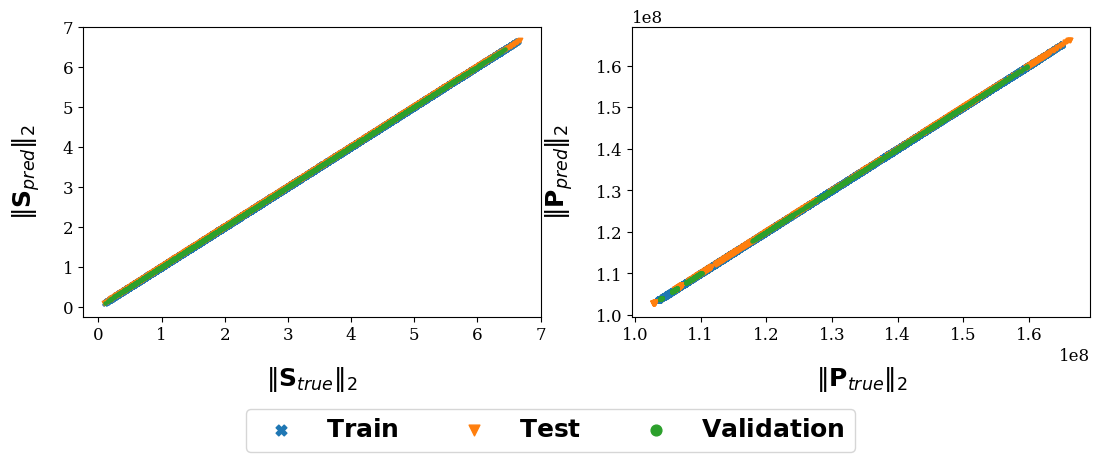

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# ax1.plot(S_true_train_norm[:, 0], S_true_train_norm[:, 0], 'r--', alpha=.5)
ax1.scatter(S_true_train_norm[:, 0], SP_pred_train_norm[:, 0], s=15, label=r'$\mathbf{Train}$', marker='X')

# ax2.plot(P_true_train_norm[:, 0], P_true_train_norm[:, 0], 'r--', alpha=.5)
ax2.scatter(P_true_train_norm[:, 0], SP_pred_train_norm[:, 1], s=15, label=r'$\mathbf{Train}$', marker='X')

# ax1.plot(S_true_test_norm[:, 0], S_true_test_norm[:, 0], 'r--', alpha=.5)
ax1.scatter(S_true_test_norm[:, 0], SP_pred_test_norm[:, 0], s=10, label=r'$\mathbf{Test}$', marker='v')

ax2.scatter(P_true_test_norm[:, 0], SP_pred_test_norm[:, 1], s=10, label=r'$\mathbf{Test}$', marker='v')

# ax1.plot(S_true_val_norm[:, 0], S_true_val_norm[:, 0], 'r--', alpha=.5)
ax1.scatter(S_true_val_norm[:, 0], SP_pred_val_norm[:, 0], s=5, label=r'$\mathbf{Validation}$', marker='o')

ax2.scatter(P_true_val_norm[:, 0], SP_pred_val_norm[:, 1], s=5, label=r'$\mathbf{Validation}$', marker='o')

ax1.set_ylabel('$\|\mathbf{S}_{pred}\|_2$', fontsize=18, labelpad=15)
ax1.set_xlabel('$\|\mathbf{S}_{true}\|_2$', fontsize=18, labelpad=15)

ax2.set_ylabel('$\|\mathbf{P}_{pred}\|_2$', fontsize=18, labelpad=15)
ax2.set_xlabel('$\|\mathbf{P}_{true}\|_2$', fontsize=18, labelpad=15)

ax1.ticklabel_format(style='sci', axis='x')
ax2.ticklabel_format(style='sci', axis='x')

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes][:1]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

plt.subplots_adjust(bottom=0.3)
lgnd = fig.legend(lines, labels, loc='lower center', ncol=3, fontsize=18)
lgnd.legend_handles[0]._sizes = [60]
lgnd.legend_handles[1]._sizes = [60]
lgnd.legend_handles[2]._sizes = [60]

# plt.savefig('parity_plot_darcy.pdf', bbox_inches = 'tight')
plt.show()

In [24]:
sample = train_df.loc[0]
P = torch.from_numpy(np.array(sample['P_init'])).reshape(1, -1, 1)
S = torch.from_numpy(np.array(sample['S0'])).reshape(1, -1, 1)
Pb = torch.from_numpy(np.full((100, 1), sample['Pb']['left'])).reshape(1, -1, 1)

P = P_normalizer.encode(P)
Pb = P_normalizer.encode(Pb)

SP_pred = torch.cat([S, P], 2).float()
SP_save = []
SP_save.append(SP_pred.detach().numpy())
SP_pred = torch.cat([SP_pred, Pb], 2).float()
for i in range(99):
  SP_pred = SP_model(SP_pred)
  SP_save.append(SP_pred.detach().numpy())
  SP_pred = torch.cat([SP_pred, Pb], 2).float()

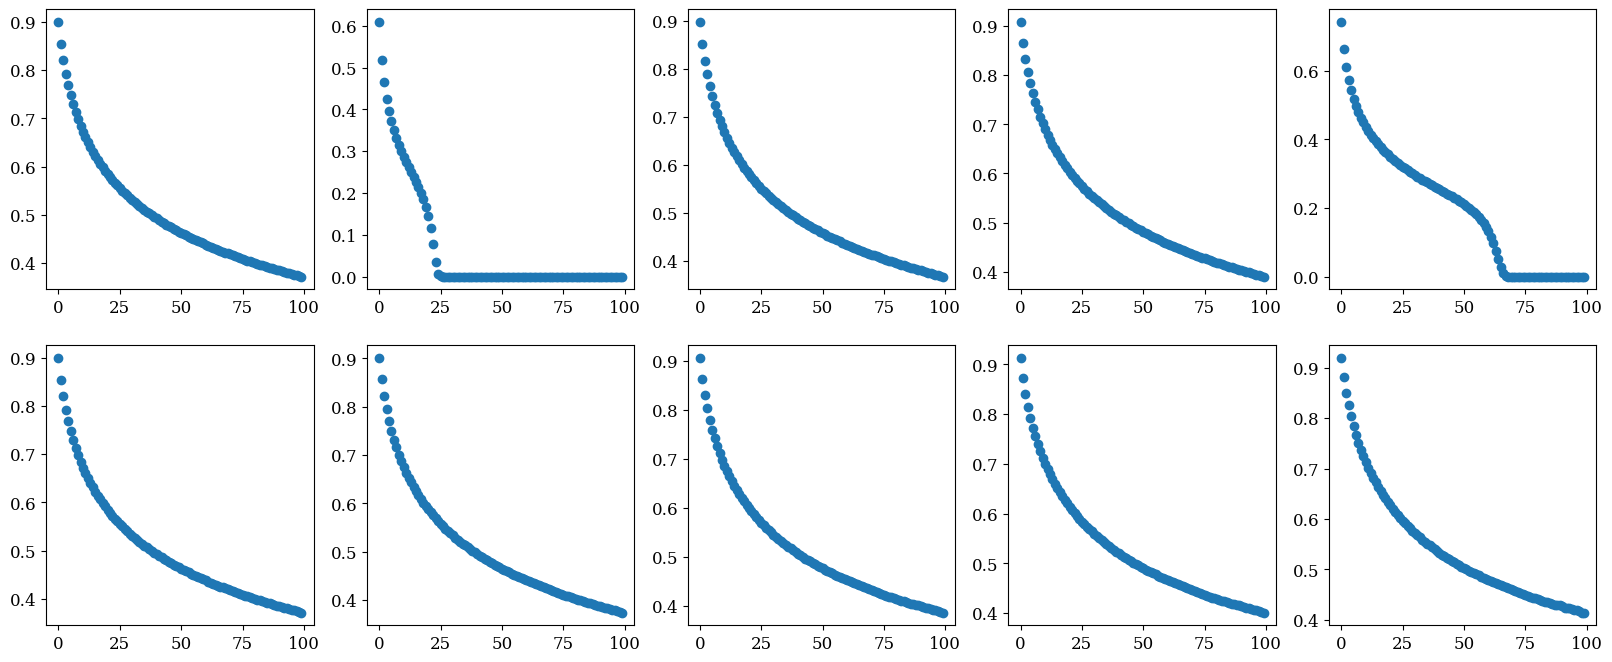

In [25]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
x = range(len(train_df.loc[0]['S0']))
ax[0][0].scatter(x, train_df.loc[0]['S'])
ax[0][1].scatter(x, train_df.loc[1]['S'])
ax[0][2].scatter(x, train_df.loc[5]['S'])
ax[0][3].scatter(x, train_df.loc[10]['S'])
ax[0][4].scatter(x, train_df.loc[15]['S'])

ax[1][0].scatter(x, SP_save[1][:, :, 0])
ax[1][1].scatter(x, SP_save[2][: ,:, 0])
ax[1][2].scatter(x, SP_save[6][: ,:, 0])
ax[1][3].scatter(x, SP_save[11][: ,:, 0])
ax[1][4].scatter(x, SP_save[16][: ,:, 0])


plt.show()

In [26]:
S_save = []
P_save = []
idxs =  [0, 50, 99]

In [27]:
for idx in idxs:
  sample = train_df.loc[idx]

  P0 = torch.from_numpy(np.array(sample['P_init'])).reshape(1, -1, 1)
  S0 = torch.from_numpy(np.array(sample['S0'])).reshape(1, -1, 1)
  Pb = torch.from_numpy(np.full(shape=(1, 100, 1), fill_value= sample['Pb']['left']))
  P0_norm = P_normalizer.encode(P0)
  Pb_norm = P_normalizer.encode(Pb)
  input = torch.cat([S0, P0_norm, Pb_norm], 2).float()
  SP_pred = SP_model(input).detach()
  S_pred = SP_pred[:, :, 0].numpy()
  P_pred = P_normalizer.decode(SP_pred[:, :, 1].unsqueeze(-1)).numpy()
  S_save.append(S_pred)
  P_save.append(P_pred)

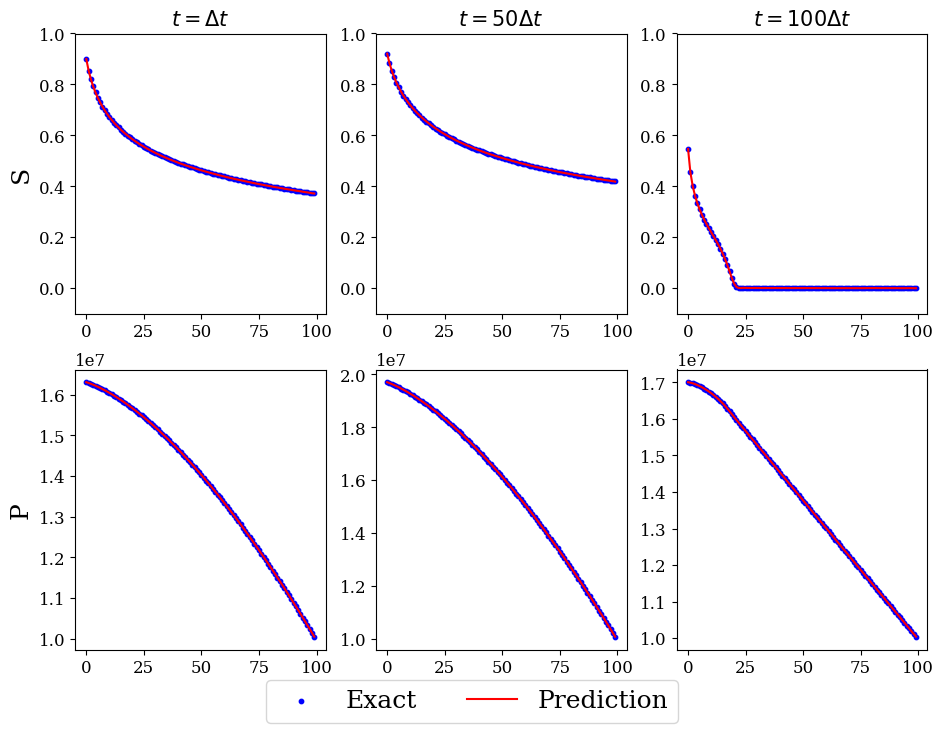

In [28]:
fig, ax = plt.subplots(2, 3, figsize=(11, 8))
x = range(len(train_df.loc[0]['S0']))
for i, idx in enumerate(idxs):
  ax[0][i].scatter(x, train_df.loc[idx]['S'], s=10, c='b', label='Exact')
  ax[0][i].plot(x, S_save[i].flatten(), c='r', ls='-', label='Prediction')
  ax[0][i].set_ylim([-0.1, 1])

  ax[1][i].scatter(x, train_df.loc[idx]['P'], s=10, c='b')
  ax[1][i].plot(x, P_save[i].flatten(), c='r', ls='-')

ax[0][0].set_ylabel('S', fontsize=18)
ax[1][0].set_ylabel('P', fontsize=18)

ax[0][0].set_title(r'$t=\Delta t$', fontsize=15)
ax[0][1].set_title(r'$t=50 \Delta t$', fontsize=15)
ax[0][2].set_title(r'$t=100 \Delta t$', fontsize=15)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes][:1]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='lower center', ncol=2, fontsize=18)
# plt.savefig('sample_pred_darcy.pdf', bbox_inches = 'tight')
plt.show()

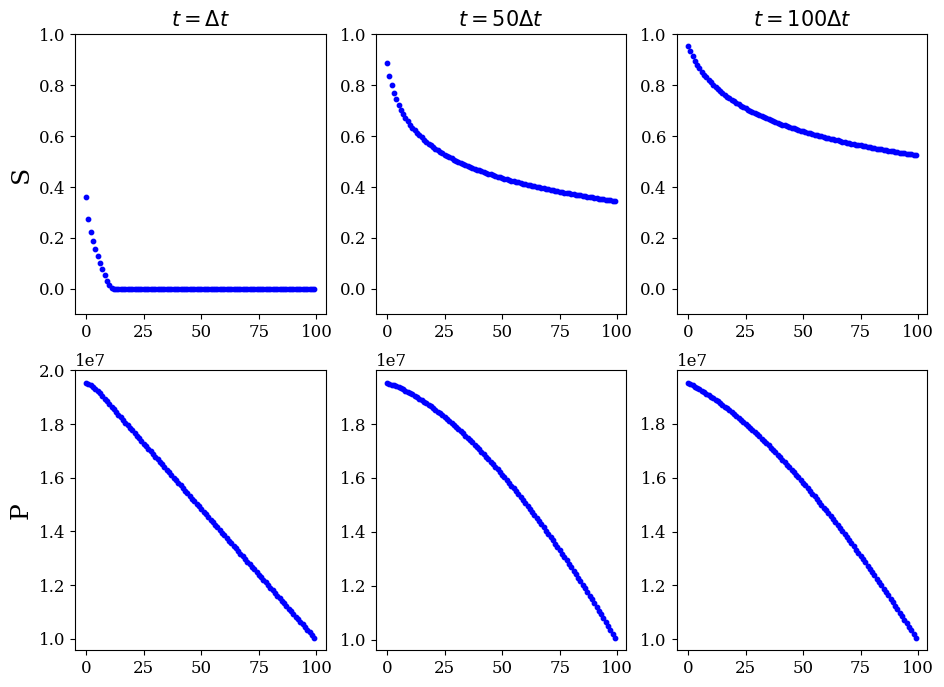

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(11, 8))
x = range(len(train_df.loc[0]['S0']))

ax[0][0].scatter(x, train_df.loc[100]['S'], s=10, c='b')
ax[0][0].set_ylim([-0.1, 1])

ax[1][0].scatter(x, train_df.loc[100]['P'], s=10, c='b')

ax[0][1].scatter(x, train_df.loc[150]['S'], s=10, c='b')
ax[0][1].set_ylim([-0.1, 1])

ax[1][1].scatter(x, train_df.loc[150]['P'], s=10, c='b')

ax[0][2].scatter(x, train_df.loc[199]['S'], s=10, c='b')
ax[0][2].set_ylim([-0.1, 1])

ax[1][2].scatter(x, train_df.loc[199]['P'], s=10, c='b')

ax[0][0].set_ylabel('S', fontsize=18)
ax[1][0].set_ylabel('P', fontsize=18)

ax[0][0].set_title(r'$t=\Delta t$', fontsize=15)
ax[0][1].set_title(r'$t=50 \Delta t$', fontsize=15)
ax[0][2].set_title(r'$t=100 \Delta t$', fontsize=15)

# plt.savefig('sample_piston_darcy.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
sample = train_df.loc[0]
P = torch.from_numpy(np.array(sample['P_init'])).reshape(1, -1, 1)
S = torch.from_numpy(np.array(sample['S0'])).reshape(1, -1, 1)
Pb = torch.from_numpy(np.full((100, 1), sample['Pb']['left'])).reshape(1, -1, 1)

P = P_normalizer.encode(P)
Pb = P_normalizer.encode(Pb)

SP_pred = torch.cat([S, P], 2).float()
SP_save_1 = []
SP_save_1.append(SP_pred.detach())
SP_pred = torch.cat([SP_pred, Pb], 2).float()
for i in range(99):
  SP_pred = SP_model(SP_pred)
  SP_save_1.append(SP_pred.detach())
  SP_pred = torch.cat([SP_pred, Pb], 2).float()

for sp in SP_save_1:
  sp[:, :, 1:] = P_normalizer.decode(sp[:, :, 1:])
  sp = sp.numpy()

# Works well
sample = train_df.loc[200]
P = torch.from_numpy(np.array(sample['P_init'])).reshape(1, -1, 1)
S = torch.from_numpy(np.array(sample['S0'])).reshape(1, -1, 1)
Pb = torch.from_numpy(np.full((100, 1), sample['Pb']['left'])).reshape(1, -1, 1)

P = P_normalizer.encode(P)
Pb = P_normalizer.encode(Pb)

SP_pred = torch.cat([S, P], 2).float()
SP_save_2 = []
SP_save_2.append(SP_pred.detach())
SP_pred = torch.cat([SP_pred, Pb], 2).float()
for i in range(99):
  SP_pred = SP_model(SP_pred)
  SP_save_2.append(SP_pred.detach())
  SP_pred = torch.cat([SP_pred, Pb], 2).float()

for sp in SP_save_2:
  sp[:, :, 1:] = P_normalizer.decode(sp[:, :, 1:])
  sp = sp.numpy()

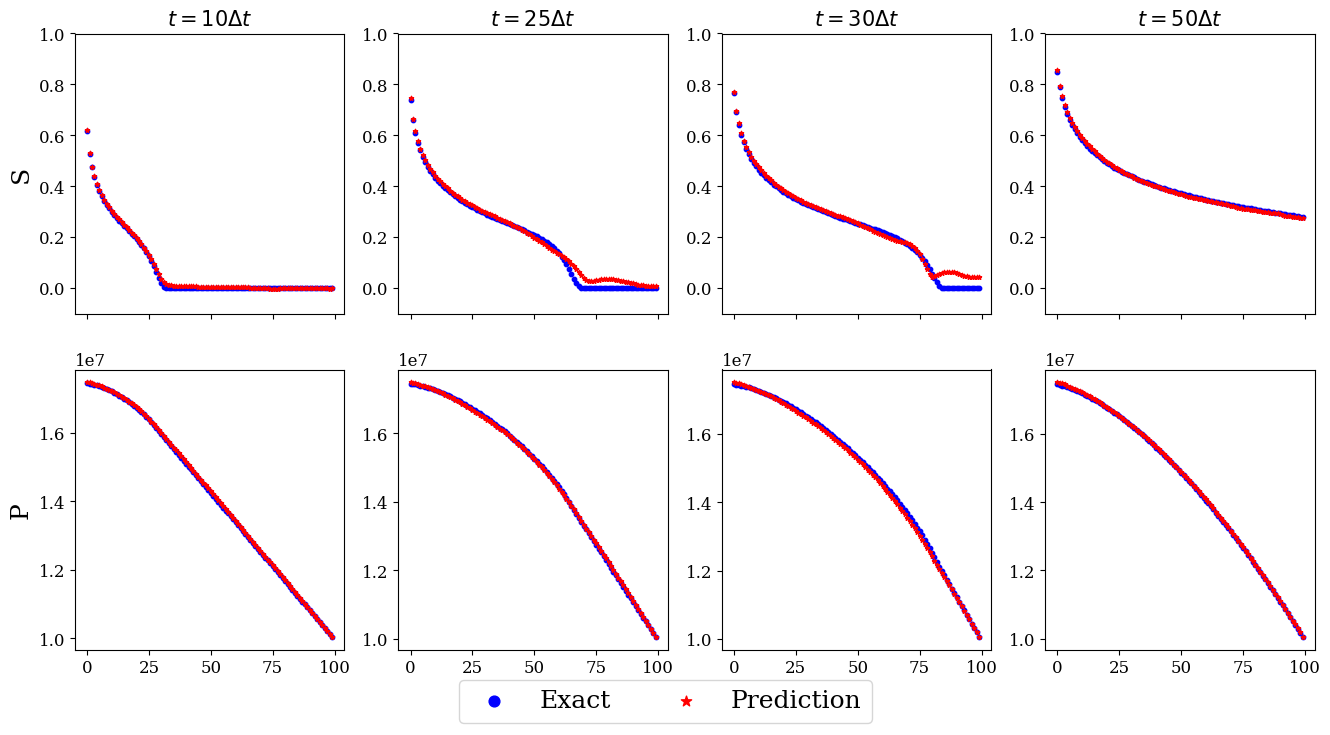

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8), sharex='all')
x = range(len(train_df.loc[0]['S0']))

ax[0][0].scatter(x, train_df.loc[200 + 10]['S'], s=10, c='b', label='Exact')
ax[0][1].scatter(x, train_df.loc[200 + 25]['S'], s=10, c='b', label='Exact')
ax[0][2].scatter(x, train_df.loc[200 + 30]['S'], s=10, c='b', label='Exact')
ax[0][3].scatter(x, train_df.loc[200 + 50]['S'], s=10, c='b', label='Exact')

ax[0][0].scatter(x, SP_save_2[11][:, :, 0], s=10, marker='*', c='r', label='Prediction')
ax[0][1].scatter(x, SP_save_2[26][: ,:, 0], s=10, marker='*', c='r', label='Prediction')
ax[0][2].scatter(x, SP_save_2[31][: ,:, 0], s=10, marker='*', c='r', label='Prediction')
ax[0][3].scatter(x, SP_save_2[51][: ,:, 0], s=10, marker='*', c='r', label='Prediction')

ax[0][0].set_title(r'$t=10 \Delta t$', fontsize=15)
ax[0][1].set_title(r'$t=25 \Delta t$', fontsize=15)
ax[0][2].set_title(r'$t=30 \Delta t$', fontsize=15)
ax[0][3].set_title(r'$t=50 \Delta t$', fontsize=15)

ax[0][0].set_ylim([-0.1, 1])
ax[0][1].set_ylim([-0.1, 1])
ax[0][2].set_ylim([-0.1, 1])
ax[0][3].set_ylim([-0.1, 1])

ax[1][0].scatter(x, train_df.loc[200 + 10]['P'], s=10, c='b', label='Exact')
ax[1][1].scatter(x, train_df.loc[200 + 25]['P'], s=10, c='b', label='Exact')
ax[1][2].scatter(x, train_df.loc[200 + 30]['P'], s=10, c='b', label='Exact')
ax[1][3].scatter(x, train_df.loc[200 + 50]['P'], s=10, c='b', label='Exact')

ax[1][0].scatter(x, SP_save_2[11][:, :, 1], s=10, marker='*', c='r', label='Prediction')
ax[1][1].scatter(x, SP_save_2[26][: ,:, 1], s=10, marker='*', c='r', label='Prediction')
ax[1][2].scatter(x, SP_save_2[31][: ,:, 1], s=10, marker='*', c='r', label='Prediction')
ax[1][3].scatter(x, SP_save_2[51][: ,:, 1], s=10, marker='*', c='r', label='Prediction')


ax[0][0].set_ylabel('S', fontsize=18)
ax[1][0].set_ylabel('P', fontsize=18)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes][:1]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
lgnd = fig.legend(lines, labels, loc='lower center', ncol=2, fontsize=18)

lgnd.legend_handles[0]._sizes = [60]
lgnd.legend_handles[1]._sizes = [60]
# plt.savefig('sample_black_box_train_good.pdf', bbox_inches = 'tight')
plt.show()

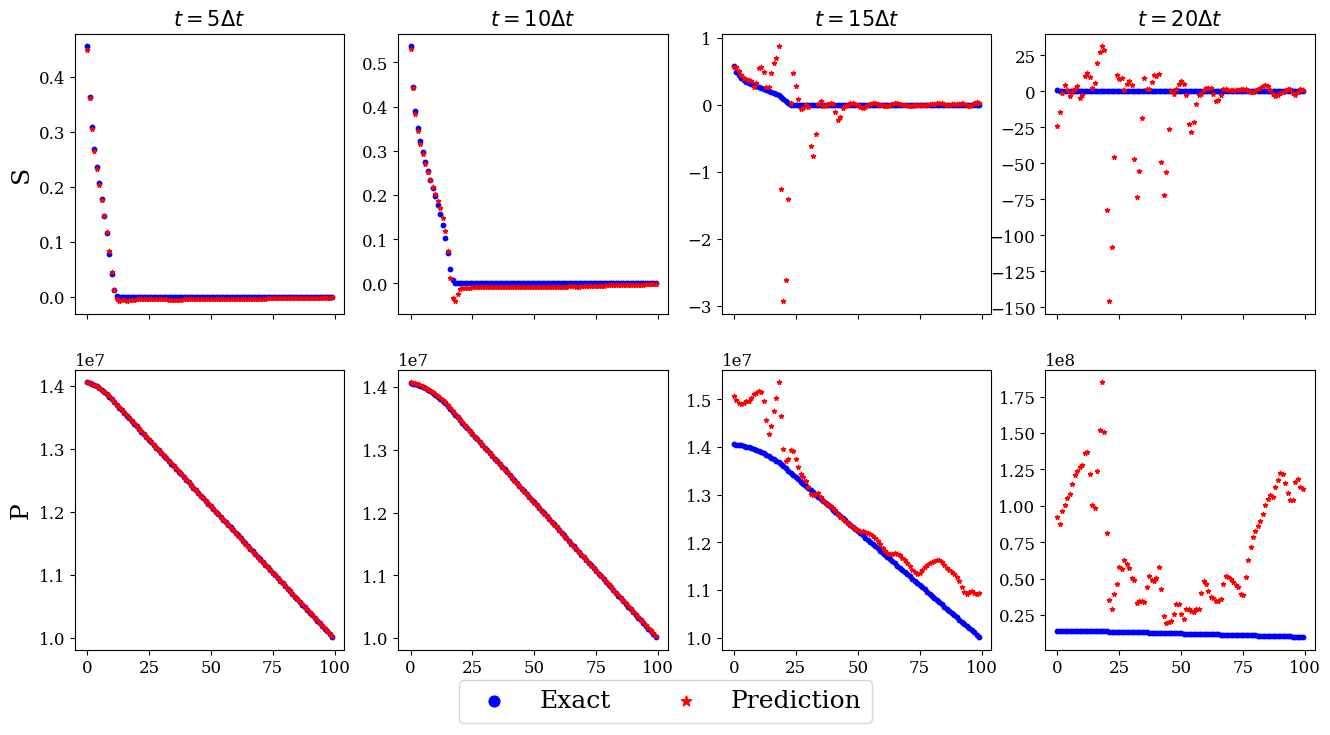

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8), sharex='all')
x = range(len(train_df.loc[0]['S0']))

ax[0][0].scatter(x, train_df.loc[5]['S'], s=10, c='b', label='Exact')
ax[0][1].scatter(x, train_df.loc[10]['S'], s=10, c='b', label='Exact')
ax[0][2].scatter(x, train_df.loc[15]['S'], s=10, c='b', label='Exact')
ax[0][3].scatter(x, train_df.loc[20]['S'], s=10, c='b', label='Exact')

ax[0][0].scatter(x, SP_save_1[6][:, :, 0], s=10, marker='*', c='r', label='Prediction')
ax[0][1].scatter(x, SP_save_1[11][: ,:, 0], s=10, marker='*', c='r', label='Prediction')
ax[0][2].scatter(x, SP_save_1[16][: ,:, 0], s=10, marker='*', c='r', label='Prediction')
ax[0][3].scatter(x, SP_save_1[21][: ,:, 0], s=10, marker='*', c='r', label='Prediction')


ax[0][0].set_title(r'$t=5 \Delta t$', fontsize=15)
ax[0][1].set_title(r'$t=10 \Delta t$', fontsize=15)
ax[0][2].set_title(r'$t=15 \Delta t$', fontsize=15)
ax[0][3].set_title(r'$t=20 \Delta t$', fontsize=15)

ax[1][0].scatter(x, train_df.loc[5]['P'], s=10, c='b', label='Exact')
ax[1][1].scatter(x, train_df.loc[10]['P'], s=10, c='b', label='Exact')
ax[1][2].scatter(x, train_df.loc[15]['P'], s=10, c='b', label='Exact')
ax[1][3].scatter(x, train_df.loc[20]['P'], s=10, c='b', label='Exact')

ax[1][0].scatter(x, SP_save_1[6][:, :, 1], s=10, marker='*', c='r', label='Prediction')
ax[1][1].scatter(x, SP_save_1[11][: ,:, 1], s=10, marker='*', c='r', label='Prediction')
ax[1][2].scatter(x, SP_save_1[16][: ,:, 1], s=10, marker='*', c='r', label='Prediction')
ax[1][3].scatter(x, SP_save_1[21][: ,:, 1], s=10, marker='*', c='r', label='Prediction')


ax[0][0].set_ylabel('S', fontsize=18)
ax[1][0].set_ylabel('P', fontsize=18)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes][:1]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
lgnd = fig.legend(lines, labels, loc='lower center', ncol=2, fontsize=18)

lgnd.legend_handles[0]._sizes = [60]
lgnd.legend_handles[1]._sizes = [60]
# plt.savefig('sample_black_box_train_bad.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
sample = train_df.loc[0]
P = torch.from_numpy(np.array(sample['P_init'])).reshape(1, -1, 1)
S = torch.from_numpy(np.array(sample['S0'])).reshape(1, -1, 1)
Pb = torch.from_numpy(np.full((100, 1), sample['Pb']['left'])).reshape(1, -1, 1)

P = P_normalizer.encode(P)
Pb = P_normalizer.encode(Pb)

SP_pred = torch.cat([S, P], 2).float()
SP_save_1 = []
SP_save_1.append(SP_pred.detach())
SP_pred = torch.cat([SP_pred, Pb], 2).float()
for i in range(99):
  SP_pred[:, :, 0] = torch.clip(SP_pred[:, :, 0], min=0., max=1.)
  SP_pred = SP_model(SP_pred)
  SP_save_1.append(SP_pred.detach())
  SP_pred = torch.cat([SP_pred, Pb], 2).float()

for sp in SP_save_1:
  sp[:, :, 1:] = P_normalizer.decode(sp[:, :, 1:])
  sp = sp.numpy()

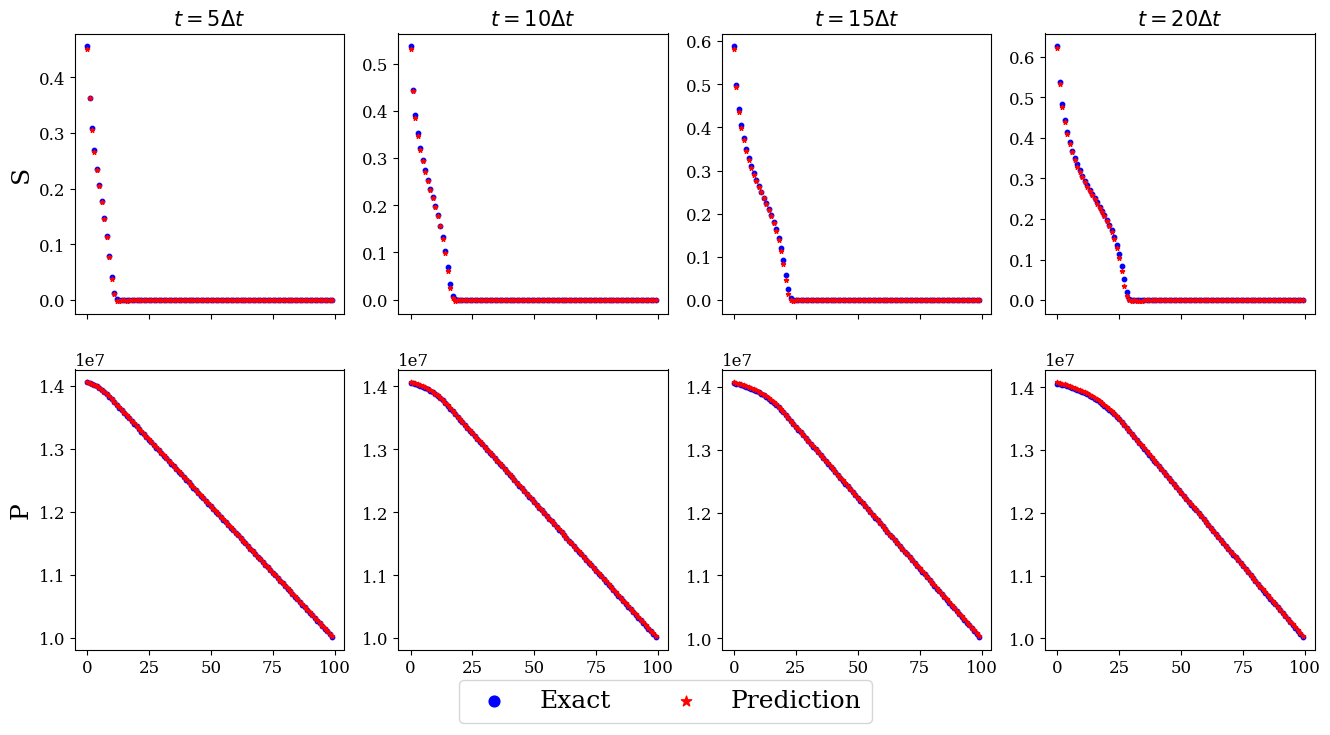

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8), sharex='all')
x = range(len(train_df.loc[0]['S0']))

ax[0][0].scatter(x, train_df.loc[5]['S'], s=10, c='b', label='Exact')
ax[0][1].scatter(x, train_df.loc[10]['S'], s=10, c='b', label='Exact')
ax[0][2].scatter(x, train_df.loc[15]['S'], s=10, c='b', label='Exact')
ax[0][3].scatter(x, train_df.loc[20]['S'], s=10, c='b', label='Exact')

ax[0][0].scatter(x, SP_save_1[6][:, :, 0], s=10, marker='*', c='r', label='Prediction')
ax[0][1].scatter(x, SP_save_1[11][: ,:, 0], s=10, marker='*', c='r', label='Prediction')
ax[0][2].scatter(x, SP_save_1[16][: ,:, 0], s=10, marker='*', c='r', label='Prediction')
ax[0][3].scatter(x, SP_save_1[21][: ,:, 0], s=10, marker='*', c='r', label='Prediction')


ax[0][0].set_title(r'$t=5 \Delta t$', fontsize=15)
ax[0][1].set_title(r'$t=10 \Delta t$', fontsize=15)
ax[0][2].set_title(r'$t=15 \Delta t$', fontsize=15)
ax[0][3].set_title(r'$t=20 \Delta t$', fontsize=15)

ax[1][0].scatter(x, train_df.loc[5]['P'], s=10, c='b', label='Exact')
ax[1][1].scatter(x, train_df.loc[10]['P'], s=10, c='b', label='Exact')
ax[1][2].scatter(x, train_df.loc[15]['P'], s=10, c='b', label='Exact')
ax[1][3].scatter(x, train_df.loc[20]['P'], s=10, c='b', label='Exact')

ax[1][0].scatter(x, SP_save_1[6][:, :, 1], s=10, marker='*', c='r', label='Prediction')
ax[1][1].scatter(x, SP_save_1[11][: ,:, 1], s=10, marker='*', c='r', label='Prediction')
ax[1][2].scatter(x, SP_save_1[16][: ,:, 1], s=10, marker='*', c='r', label='Prediction')
ax[1][3].scatter(x, SP_save_1[21][: ,:, 1], s=10, marker='*', c='r', label='Prediction')


ax[0][0].set_ylabel('S', fontsize=18)
ax[1][0].set_ylabel('P', fontsize=18)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes][:1]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
lgnd = fig.legend(lines, labels, loc='lower center', ncol=2, fontsize=18)

lgnd.legend_handles[0]._sizes = [60]
lgnd.legend_handles[1]._sizes = [60]
plt.savefig('sample_black_box_train_bad_clipping.pdf', bbox_inches = 'tight')
plt.show()